<img src="monai.png" style="width: 700px;"/>

Welcome to the MONAI bootcamp! This notebook will introduce you to the MONAI design and architecture, and then hands-on with its transforms.

### Using Google Colab

This notebook has the pip command for installing MONAI and will be added to any subsequent notebook.

**Required Packages for Colab Execution**

Execute the following cell to install MONAI the first time a colab notebook is run:


In [1]:
!pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.6.0"

**Enabling GPU Support**

To use GPU resources through Colab, change the runtime to GPU:

1. From the **"Runtime"** menu select **"Change Runtime Type"**
2. Choose **"GPU"** from the drop-down menu
3. Click **"SAVE"**

This will reset the notebook and probably ask you if you are a robot (these instructions assume you are not). Running

**!nvidia-smi**

in a cell will verify this has worked and show you what kind of hardware you have access to.    

In [2]:
!nvidia-smi

Thu Jan 27 09:20:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 207...  Off  | 00000000:02:00.0 Off |                  N/A |
| 35%   32C    P8    15W / 215W |     10MiB /  7982MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Getting Started with MONAI
---

MONAI is a PyTorch-based, open-source framework for deep learning in healthcare imaging, part of PyTorch Ecosystem.

*Its ambitions are:*

- developing a community of academic, industrial and clinical researchers collaborating on a common foundation;
- creating state-of-the-art, end-to-end training workflows for healthcare imaging;
- providing researchers with the optimized and standardized way to create and evaluate deep learning models.

MONAI aims at supporting deep learning in medical image analysis at multiple granularities. This figure shows a typical example of the end-to-end workflow in medical deep learning area:

<img src="end_to_end.png" style="width: 700px;"/>

## What's the Need?

* Biomedical applications have specific requirements
* Image modalities (MR, CT, US, etc.) require specific data processing
* Data formats (DICOM, NIfTI, etc.) are specific to medical applications and require special support
* Certain network architectures are designed for, or are highly suitable for, biomedical applications
* Data transforms specific to biomedical applications, and to image modalities, are very useful when pre-processing data, augmenting data during training, and post-processing
* Reproducible science requires reproducible experiments which in turn rely on software accessible to other scientists, even if just as a common baseline
* A community-driven library to provide solutions to these requirements reduces duplication/re-implementation
* Baseline implementations of common networks, and implementations of networks specific to certain papers, provides a basis for comparison between other's networks and results

## How Does MONAI Address This Need?

MONAI provides a framework of deep learning facilities and infrastructure to meet these needs in a flexible Pytorch-compatible way:
* Data loading and handling library for biomedical file types
* Large set of data transforms to process, regularize, and augment image date before, during, and after training
* Library of general-purpose network, metric, and loss function definitions implementing common architectures
* Set of ready-made components for training and inference to utilize computing infrastructure efficiently

MONAI contributes to reproducibilty by making the training and distribution of experiments easier:
* Common underlying framework betweeen different users' implementations aids in comparison and interoperability
* Users can pick and choose components and existing networks then contribute new code to make their results available to others
* Reference implementations of networks from papers provides baselines for replication studies and comparisons


## MONAI architecture
The design principle of MONAI is to provide flexible and light APIs for users with varying expertise. All the core components are independent modules, which can be easily integrated into any existing PyTorch programs. Users can leverage the workflows in MONAI to quickly set up a robust training or evaluation program for research experiments.  Rich examples and demos are provided to demonstrate the key features. Researchers contribute implementations based on the state-of-the-art for the latest research challenges, including COVID-19 image analysis, Model Parallel, etc.

<img src="arch_modules_v0.4.png" style="width: 700px;"/>

## MONAI Design Philosophy

Key principles:
* MONAI looks like PyTorch, uses/extends PyTorch types and adheres to it's general design philosophy
* MONAI is additive on top of PyTorch, providing extensions or wrappers
* MONAI is opt-in and incremental, no need to rewrite entire models to integrate existing code
* MONAI is collaborative, providing adapters and loosely coupled components to ease integration with third party code
* MONAI is PyTorch ecosystem friendly, and part of the official ecosystem!




## MONAI Transforms

To help you understand more about MONAI transforms, this guide will help you answer five key questions:

1. **What transforms are available to help create a data pipeline for training?**
2. **What are array transforms?**
3. **What is required to write a custom transform?**
4. **What are dictionary transforms?**
5. **How do I create a basic MONAI dataset with transforms?**

Let's get started by importing our dependecies.  We're going to load everything that we'll need for the remainder of the notebook here.  You'll see a lot of import statements, but we'll make sure to go over each of them throughout the rest of the notebook.

In [3]:
import tempfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Any, Mapping, Hashable

import monai
from monai.config import print_config
from monai.utils import first
from monai.config import KeysCollection
from monai.data import Dataset, ArrayDataset, create_test_image_3d, DataLoader
from monai.transforms import (
    Transform,
    MapTransform,
    Randomizable,
    AddChannel,
    AddChanneld,
    Compose,
    LoadImage,
    LoadImaged,
    Lambda,
    Lambdad,
    RandSpatialCrop,
    RandSpatialCropd,
    ToTensor,
    ToTensord,
    Orientation, 
    Rotate
)
print_config()

MONAI version: 0.6.0
Numpy version: 1.21.2
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.4.0
Tensorboard version: 2.8.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.0
ITK version: 5.2.1
tqdm version: 4.61.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## **1. What transforms are available to help create a data pipeline for training?**

#### Medical image data I/O, processing and augmentation

Medical images require highly specialized methods for I/O, preprocessing, and augmentation. Medical images are often in specialized formats with rich meta-information, and the data volumes are often high-dimensional. These require carefully designed manipulation procedures. The medical imaging focus of MONAI is enabled by powerful and flexible image transformations that facilitate user-friendly, reproducible, optimized medical data pre-processing pipelines.

<img src="medical_transforms.png" style="width: 700px;"/>

#### Transforms support both Dictionary and Array format data
The widely used computer vision packages (such as torchvision) focus on spatially 2D array image processing. MONAI provides more domain-specific transformations for both spatially 2D and 3D and retains the flexible transformation “compose” feature.

As medical image preprocessing often requires additional fine-grained system parameters, MONAI provides transforms for input data encapsulated in python dictionaries. Users can specify the keys corresponding to the expected data fields and system parameters to compose complex transformations.

There is a rich set of transforms in six categories: Crop & Pad, Intensity, IO, Post-processing, Spatial, and Utilities. For more details, please visit all the transforms in MONAI.

#### Medical specific transforms
MONAI aims at providing a comprehensive medical image specific transformations. These currently include, for example:

    - LoadImage: Load medical specific formats file from provided path
    - Spacing: Resample input image into the specified pixdim
    - Orientation: Change the image’s orientation into the specified axcodes
    - RandGaussianNoise: Perturb image intensities by adding statistical noises
    - NormalizeIntensity: Intensity Normalization based on mean and standard deviation
    - Affine: Transform image based on the affine parameters
    - Rand2DElastic: Random elastic deformation and affine in 2D
    - Rand3DElastic: Random elastic deformation and affine in 3D

We'll create a temporary directory and populate it with a few example Nifti file-format images containing a random assortment of spheres.  We're also creating a matching segmentation pair that will be used later in the notebook.

In [4]:
fn_keys = ("img", "seg")  # filename keys for image and seg files

root_dir = tempfile.mkdtemp()
filenames = []

for i in range(5):
    im, seg = create_test_image_3d(256, 256, 256, num_objs=25, rad_max=50)

    im_filename = f"{root_dir}/im{i}.nii.gz"
    seg_filename = f"{root_dir}/seg{i}.nii.gz"
    filenames.append({"img": im_filename, "seg": seg_filename})

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, im_filename)

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, seg_filename)

## 2. **What are array transforms?**

Transforms in MONAI are callable objects accepting inputs from initial data in a dataset or previous transforms. We can create and call these directly without any infrastructure or system setup as components in MONAI are designed to be as decoupled as possible. For example we can load one of our Nifti files directly by creating the transform and calling it.

Transforms are composed with `Compose` to create a sequence of operations. `Compose` itself being a transform we can also call it directly. The type of img here is `numpy.ndarray` so to convert to a Pytorch tensor as part of a training data pipeline we'd have `ToTensor` as the last transform in our sequence:

In [5]:
trans = Compose([LoadImage(image_only=True), AddChannel(), ToTensor()])
img = trans(filenames[0]["img"])
print(type(img), img.shape, img.get_device())

<class 'torch.Tensor'> torch.Size([1, 256, 256, 256]) -1


## **3. How do I create a custom transform?**
We can define our own custom transform operation in a number of ways. If a simple callable is used as an operator, `Lambda` can be used to wrap it as a transform. We define in this example a transform to sum the image in the 1st (width) dimension to produce a 2D image:

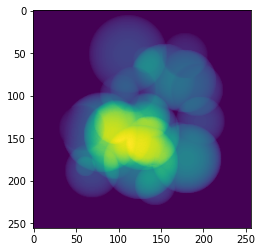

In [7]:
def sum_width(img):
    return img.sum(1)

trans = Compose([LoadImage(image_only=True), AddChannel(), Lambda(sum_width)])
img = trans(filenames[0]["img"])
plt.imshow(img[0])

Creating a subclass of Transform is the second method, and this has the advantage of being able to define attributes with the instantiated objects. Let's define a class to sum in a chosen dimension, and use it to sum in the 2nd (height) dimension:

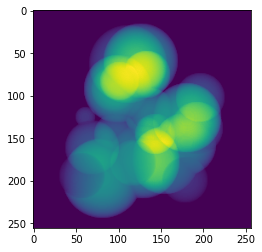

In [8]:
class SumDimension(Transform):
    def __init__(self, dim=1):
        self.dim = dim

    def __call__(self, inputs):
        return inputs.sum(self.dim)

trans = Compose([LoadImage(image_only=True), AddChannel(), SumDimension(2)])
img = trans(filenames[0]["img"])
plt.imshow(img[0])

All of these example transforms so far have been deterministic, to define transforms which perform some stochastic operation on input data we want to also inherit from `Randomizable`. This class is used to randomize variables but also distinguish from deterministic transforms. We'll see why this is important later in caching data loaders. 

In this class we have a `numpy.random.RandomState` object to provide stochastic values. This can be replaced using `Randomizable.set_random_state()` to control the randomization process. The `randomize()` method is responsible for determining if the random operation is to be performed based on the `prob` probability member, then creates the random noise array if so. This functionality is in this method so that it can be called by `Compose` or other external controllers. 

For now lets define a simple transform to add noise. 

**Run this cell a few times to see the random transform being applied 50% of the time.**

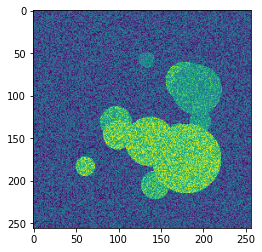

In [13]:
class RandAdditiveNoise(Randomizable, Transform):
    def __init__(self, prob: float = 0.5, max_add: float = 1.0) -> None:
        self.prob = np.clip(prob, 0.0, 1.0)
        self.max_add = max_add
        self._noise = 0

    def randomize(self, data: np.ndarray) -> None:
        self._noise = 0

        if self.R.random() < self.prob:
            noise_array = self.R.rand(*data.shape[1:])[None]
            self._noise = (noise_array * self.max_add).astype(data.dtype)

    def add_noise(self, img: np.ndarray) -> np.ndarray:
        return img + self._noise

    def __call__(self, img: np.ndarray) -> np.ndarray:
        self.randomize(img)
        return self.add_noise(img)

trans = Compose([LoadImage(image_only=True), AddChannel(), RandAdditiveNoise()])
img = trans(filenames[0]["img"])
plt.imshow(img[0, 128])

## **4. What are dictionary transforms?**

So far we have seen transforms which are applied to individual Numpy arrays, however for most training schemes a pipeline with multiple values is needed. To address this MONAI includes transforms for operating on dictionaries of arrays, one for each equivalent array transform. These can be applied to named values in an input dictionary while leaving unnamed values untouched, for example adding noise to an image while leaving the associated label image untouched.

Earlier in the notebook we imported the dictionary equivalent transforms which have a `d` appended to their names, we'll use those transforms in this section.  The `keys` argument in `LoadNiftid` is used to state which keys contain paths to Nifti files, all other values in the input dictionary will be retained. With this set we can look at the keys returned when calling the transform:

In [14]:
trans = LoadImaged(keys=fn_keys)
data = trans(filenames[0])
print(list(data.keys()))

['img', 'seg', 'img_meta_dict', 'seg_meta_dict']


`Lambdad` applies the given callable to each array named by `keys` separately. We can use this to define transforms operating on different named values in the dictionary at different points in the sequence:

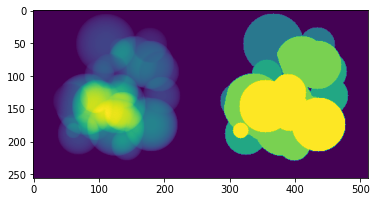

In [16]:
def sum_width(img):
    return img.sum(1)

def max_width(img):
    return img.max(1)

trans = Compose([LoadImaged(fn_keys), AddChanneld(fn_keys), Lambdad(("img",), sum_width), 
                 Lambdad(("seg",), max_width)])

imgd = trans(filenames[0])
img = imgd["img"]
seg = imgd["seg"]

plt.imshow(np.hstack((img[0] * 5 / img.max(), seg[0])))

The above applies one operation to one member of the dictionary and different operation to another. A reasonable re-implementation of this in one transform would require retaining the names of which members to apply which transform to and applying the operations in one method. Adapting array-based transforms to operate over dictionaries is relatively straight-forward.

**Run this cell a few times to see the random transform being applied 50% of the time.**

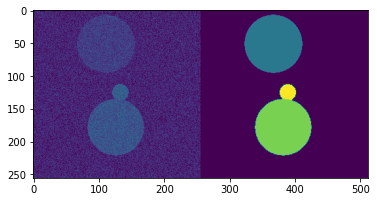

In [20]:
class RandAdditiveNoised(Randomizable, MapTransform):
    def __init__(
        self, keys: KeysCollection, prob: float = 0.5, max_add: float = 1.0
    ) -> None:
        super(Randomizable, self).__init__(keys)
        self.transform = RandAdditiveNoise(prob, max_add)

    def set_random_state(
        self, seed: Optional[int] = None, state: Optional[np.random.RandomState] = None
    ) -> "RandAdditiveNoised":
        self.transform.set_random_state(seed, state)
        super().set_random_state(seed, state)
        return self

    def randomize(self, data: Optional[Any] = None) -> None:
        self.transform.randomize(data)

    def __call__(
        self, data: Mapping[Hashable, np.ndarray]
    ) -> Mapping[Hashable, np.ndarray]:
        self.randomize(data[monai.utils.first(self.keys)])

        d = dict(data)
        for key in self.keys:
            d[key] = self.transform.add_noise(d[key])
        return d

trans = Compose([LoadImaged(fn_keys), AddChanneld(fn_keys), RandAdditiveNoised(("img",))])
img = trans(filenames[0])

# We're adding random noise to the image, not the segmentation
plt.imshow(np.hstack([img["img"][0, 50], img["seg"][0, 50]])) 

Method overrides are provided to delegate behaviour to an internal `RandAdditiveNoise` instance:
* `set_random_state` sets the state of the delegate and the current object
* `randomize` delegates the randomization to the `RandAdditiveNoise` instance
* `__call__` causes the delegate to randomize then applies the transform to each named member of the dictionary. The delegate transform is randomized only once, this ensures the same random field is added to each named member of the dictionary, a slightly different implementation adding a per-key random field would be needed if this were the desired behaviour. 

## **5. How do I create a basic MONAI dataset with transforms?**

Now that we've taken a look at transform, let's take a look at datasets. With a data source and transforms defined we can now create a dataset object. The base class for MONAI is `Dataset`, created here to load the image Nifti files only.

`Dataset` inherits from the Pytorch class of that name and adds only the ability to apply the given transform to selected items. If you're familiar with the class from Pytorch this will work the same way. 

In [21]:
images = [fn["img"] for fn in filenames]

transform = Compose([LoadImage(image_only=True), AddChannel(), ToTensor()])
ds = Dataset(images, transform)
img_tensor = ds[0]
print(img_tensor.shape, img_tensor.get_device())

torch.Size([1, 256, 256, 256]) -1


MONAI provides the `ArrayDataset` for supervised training applications specifically. It can accept data arrays for images separate from those for segmentations or labels with their own separate transforms. Here we will again separate out the image and segmentation filenames to demonstrate this usage:

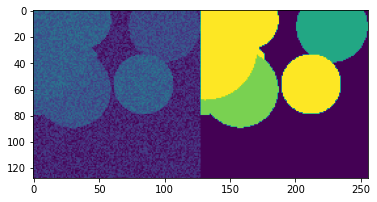

In [24]:
images = [fn["img"] for fn in filenames]
segs = [fn["seg"] for fn in filenames]

img_transform = Compose([LoadImage(image_only=True), AddChannel(), 
                         RandSpatialCrop((128, 128, 128), random_size=False), RandAdditiveNoise(), ToTensor()])
seg_transform = Compose([LoadImage(image_only=True), AddChannel(), 
                         RandSpatialCrop((128, 128, 128), random_size=False), ToTensor()])

ds = ArrayDataset(images, img_transform, segs, seg_transform)
im, seg = ds[0]
plt.imshow(np.hstack([im.numpy()[0, 48], seg.numpy()[0, 48]]))

Instead of returning a single image, accessing a member of the dataset produces a pair containing the image and segmentation after being pass through their respective transforms. One important aspect of this class is that the random state of each transform (`Compose` in this case) is set to that of the dataset before being applied. This ensures the same random operations are applied to each output, which is why the `RandSpatialCrop` operation chooses the same crop window for the image as well as the segmentation. By having separate transforms one can apply operations to images and not to segmentations (or vice versa), being careful that these unshared operations come after the shared ones.

Alternatively, `Dataset` can be used with dictionary-based transforms to construct a result mapping. For training applications beyond simple input/ground-truth pairs like the above this would be more suitable:

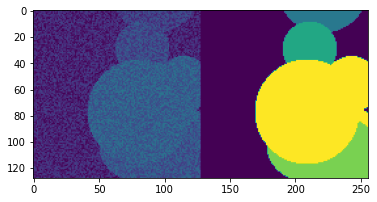

In [25]:
trans = Compose([LoadImaged(fn_keys), AddChanneld(fn_keys), RandAdditiveNoised(("img",)), 
                 RandSpatialCropd(fn_keys, (128, 128, 128), random_size=False), ToTensord(fn_keys)])

ds = Dataset(filenames, trans)
item = ds[0]
im, seg = item["img"], item["seg"]
plt.imshow(np.hstack([im.numpy()[0, 48], seg.numpy()[0, 48]]))

With the dataset defined, we can now create the dataloader to create data batches. This inherits directly from Pytorch's `DataLoader` class with a few changes to the default constructor arguments. MONAI functionality should be compatible with the PyTorch DataLoader, but it was subclasses to include additional functionality that we consider key and which cannot be realized with the standard DataLoader class.

The `DataLoader` will use five worker processes to load the actual data. MONAI provides a number of `Dataset` subclasses to improve the efficiency of this process. These and other features will be covered in subsequent labs.

['img', 'seg', 'img_meta_dict', 'seg_meta_dict', 'img_transforms', 'seg_transforms'] torch.Size([5, 1, 128, 128, 128])


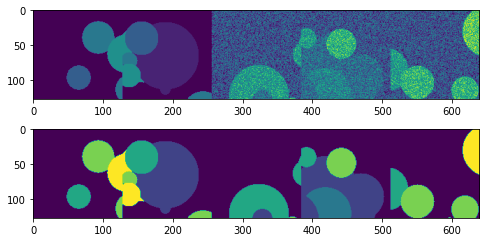

In [26]:
loader = DataLoader(ds, batch_size=5, num_workers=5)
batch = first(loader)
print(list(batch.keys()), batch["img"].shape)

f, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].imshow(np.hstack(batch["img"][:, 0, 64]))
ax[1].imshow(np.hstack(batch["seg"][:, 0, 64]))

## **Summary**

We've covered MONAI Transforms.  Some key highlights are:

- There is a long list of medical specific transforms available in MONAI
- There are array and dictionary versions of transforms.
- You can create a simple callable lambda function or create a class based on transform to create your own custom tranform
- You can create a MONAI dataset and directly pass a compose tranform chain to it

## **Assignment 1**

Now you get to practice creating a transform of your own and integrating it into a compose array.

Create a transform which selects a patch from an input image of a given size and randomly chooses to transpose this data along randomly chosen axes. For example, this could produce an image where a patch in the center has been flipped in the horizontal direction while the rest of the image is left unchanged.

Assumptions:
* Implement this as an array randomized transform
* Use a default probability ratio of 40% chance to crop
* Use one of the test 3D images from above to validate
* Default crop size is 150 but allow it to be variable
* Don't worry about edge cases

Below is the initial class definition you'll need to implement.  We also include a compose chain and image visualization call that should work once your function is fully implemented.

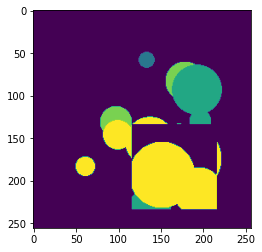

In [35]:
class RandFlipRect(Randomizable, Transform):
    """
    Define a transform to randomly transpose a patch of the input image along randomly chosen spatial dimensions. This 
    uses arguments `prob` for the probability the transform is applied, and `size` giving the size of the cube to flip.
    """
    def __init__(self, prob: float = 0.4, size: int = 100) -> None:
        self.prob = np.clip(prob, 0.0, 1.0)
        self.size = size

    def random_flip(self, data: np.ndarray) -> np.ndarray:
        if self.R.random() < self.prob:
            height = data.shape[1]
            width = data.shape[2]
            depth = data.shape[3]
            
            # Select subpatch of image
            x = self.R.randint(0, height - self.size)
            y = self.R.randint(0, width - self.size)
            z = self.R.randint(0, depth - self.size)
            patch = data[...,x:x+self.size,y:y+self.size,z:z+self.size]
            
            # apply random flipping
            if self.R.random() < 0.333:
                patch = patch[..., ::-1, :, :]
            if self.R.random() < 0.333:
                patch = patch[..., :, ::-1, :]
            if self.R.random() < 0.333:
                patch = patch[..., :, :, ::-1]
                
            data[...,x:x+self.size,y:y+self.size,z:z+self.size] = patch
        return data

    def __call__(self, img: np.ndarray) -> np.ndarray:
        return self.random_flip(img)
    
trans = Compose([LoadImage(image_only=True), AddChannel(), RandFlipRect()])
img = trans(filenames[0]["img"])
plt.imshow(img[0, img.shape[1]//2])

## **Assignment 2**

In the cell below define a dictionary-based transform pipeline which will take input images and segmentations and ensure:
* both image and segmentation arrays have a channel dimension
* each image/segmentation pair is 200x200x200 pixels in shape
* the value range of each image is between 0 and 1
* the dtype of the image is float32 and that of the segmentation is int32
* both are produced in the end as tensors

All this can be done with built-in transforms so you shouldn't need a lambda transform. Once your pipeline works, use it to construct and dataset and then a data loader. Iterate over every value in the data loader and check that the image and segmentation members of the produced dictionaries meet these requirements.

torch.Size([1, 200, 200, 200])
torch.float32 torch.int32
tensor(0.) tensor(1.)
tensor([0, 1, 2, 3, 4, 5], dtype=torch.int32)
torch.Size([3, 1, 200, 200, 200])
torch.float32 torch.int32
tensor(0.) tensor(1.)
tensor([0, 1, 2, 3, 4, 5], dtype=torch.int32)
torch.Size([2, 1, 200, 200, 200])
torch.float32 torch.int32
tensor(0.) tensor(1.)
tensor([0, 1, 2, 3, 4, 5], dtype=torch.int32)


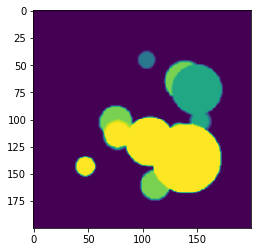

In [45]:
import torch
from monai.transforms import LoadImaged, AddChanneld, CastToTyped, ToTensord, Resized, ScaleIntensityd

trans = Compose(
    [
        LoadImaged(fn_keys, image_only=True), 
        AddChanneld(fn_keys),
        Resized(fn_keys, spatial_size=(200,200,200)),
        ScaleIntensityd(("img",),minv=0, maxv=1),
        CastToTyped(fn_keys,dtype=(np.float32, np.int32)),
        ToTensord(fn_keys),
    ]
)

data = trans(filenames[0])
img = data["img"]
seg = data["seg"]

print(img.shape)  # should be (1, 200, 200, 200)
print(img.dtype, seg.dtype)  # should be float32  int32
print(img.min(), img.max())  # should be 0.0 1.0
print(torch.unique(seg))  # should be [0 1 2 3 4 5]

plt.imshow(img[0, img.shape[1] // 2])

# construct dataset and dataloder here and iterate over batches, batch_size of 1 should be used

ds = Dataset(filenames, transform=trans)
loader = DataLoader(ds, batch_size=3)

for batch in loader:
    img = batch["img"]
    seg = batch["seg"]
    
    print(img.shape)  # should be (1, 200, 200, 200)
    print(img.dtype, seg.dtype)  # should be float32  int32
    print(img.min(), img.max())  # should be 0.0 1.0
    print(torch.unique(seg))  # should be [0 1 2 3 4 5]
    
    

## **Next Steps**

In the next notebook, we cover more advanced uses of dataset and dataset caching.

You can find more information about everything covered here on our [MONAI Documentation Page](https://docs.monai.io/).  

If you're looking for more examples and tutorials, we have a repo dedicated just to that!  You can find it on our [GitHub Organization Page](https://github.com/Project-MONAI/tutorials). 